# Building and training a neural network with TensorFlow

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 

print(tf.__version__)
print("GPU Available: ", tf.test.is_gpu_available())


1.14.0
GPU Available:  True


In [3]:
# Making sure GPUs are enabled
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Loading data

We will work for now with the fashion mnist dataset, which can be downloaded within tensorflow. It is a classification datasets composed of 28x28 black and white images of 10 different types of fashion items.

In [0]:
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


4431872/4422102 [==============================] - 0s 0us/step


Let's take a look at the images

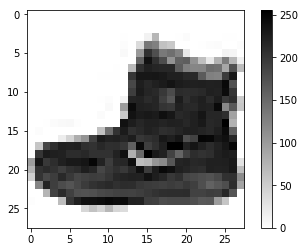

In [0]:
plt.figure()
plt.imshow(train_images[0], cmap=plt.cm.binary)
plt.colorbar()
plt.show()

### Rescaling the data
Right now, the data is composed of pixels with values ranging from 0 to 256. We usually do some preprocessing on the data before training a model called Feature scaling (https://en.wikipedia.org/wiki/Feature_scaling ). There are different ways of doing so. Here we'll use __MinMax-Normalization__, where the 'normalized' data are computed with:
$x' = \frac{x - min(x)}{max(x) - min(x)}$
Note that we usually compute the min/max (or mean std etc) on the training set only. Also, it is normally done 'per feature' : if your input is a vector composed of an 'age' feature, a 'height', etc. you want each feature to be expressed in a 'comparable' way. Here because w work with images, we do it accross all features (all pixels). If we had differnt channels (e.g. RGB) we should however compute the min/max on each channel (but it is usually coherent!)

We'll see more details on pre-processing your data on the next tutorial !

More refs: 
https://sebastianraschka.com/Articles/2014_about_feature_scaling.html
https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#sphx-glr-auto-examples-preprocessing-plot-all-scaling-py
https://towardsdatascience.com/normalization-vs-standardization-quantitative-analysis-a91e8a79cebf

In [0]:
## Do the MinMax normalization:


max_ = np.max(train_images)
min_ = np.min(train_images)
print(max_)
print(min_)
train_images = (train_images - min_) / (max_ - min_)
test_images = (test_images - min_) / (max_ - min_)

255
0


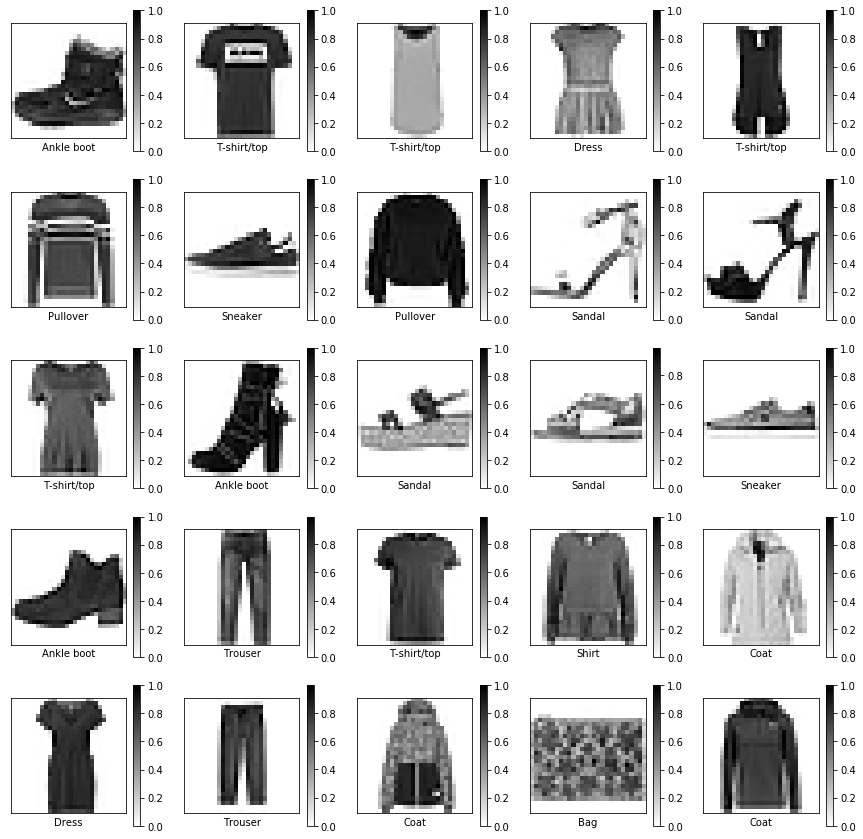

In [0]:
# Let's plot a bunch of images with the corresponding labels

plt.figure(figsize=(15,15))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
    plt.colorbar()
plt.show()


We also see that the pixels value always range between 0 and 1 after MinMax Normalization.

## Building a multi layer perceptron (MLP)

The most common type of model is a stack of layers: the tf.keras.Sequential model. You will assemble layers to build models by using the *add* function. 
You can stack different types of layers provided by tf.keras.layers : https://www.tensorflow.org/api_docs/python/tf/keras/layers 

Let's start simple : right now, we have 28x28 images, but a vanilla multi layer perceptron will only take vectors as input. So the first layer of your model should *flatten* the input to transform our matrix into a 784 vector.
You can also indicate the future input shape taken as input for this layer, using the *input_shape* argument.


Then, let's stack 2 fully (densely) connected layers ( https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense ) with an output size of 128 each, and using the ReLU activation function.

Our final layer will also be a fully connected layer, but we need to predict 10 outputs that can be interpreted as a probability distribution so we need a softmax activation function
https://www.tensorflow.org/api_docs/python/tf/keras/activations

In [0]:
model = tf.keras.models.Sequential()

In [0]:
## Add your layers !

model.add(tf.keras.layers.Flatten(input_shape=(28,28)))
model.add(tf.keras.layers.Dense(128, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(128, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(10, activation=tf.nn.softmax))

W0821 20:55:26.357144 139652486629248 deprecation.py:506] From /usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling __init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [0]:
# You can check your model's architecture using the following :
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
Total params: 118,282
Trainable params: 118,282
Non-trainable params: 0
_________________________________________________________________


Now let's configure the training process, using the *compile* function. 

https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile

You will need to setup three paramters : 
- *optimizer*, which select the optimization algorithm to use during training. You can safely go with Adam optimizer.
- *loss* : this is the criterion that the model will optimize, e.g. mean square error (mse), categorical crossentropy, binary cross entropy, etc.https://www.tensorflow.org/api_docs/python/tf/keras/losses  Here we are in a classification setting, with more than two labels. Note that the targets are encoded as single integers (i.e. not _one-hot_ vectors, see train_labels.shape).
- *metrics* : used to monitor training. In our case, we want to check that the accuracy is increasing with training. 


In [0]:
train_labels.shape

(60000,)

In [0]:


model.compile(optimizer='adam',
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

 

## Training

Let's train this model ! We will need to use the *fit* function : https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit

Call this function with the training inputs, the training labels (target), the number of epochs (e.g. 5). You can also select up the batch size, and decide to use a part of the dataset as validation with *validation_split*, for instance to be sure you're not overfitting.


In [0]:

hist = model.fit(train_images, train_labels, epochs=3, batch_size=10, validation_split=0.2)

Train on 48000 samples, validate on 12000 samples
Epoch 1/3
48000/48000 [==============================] - 14s 283us/sample - loss: 0.4913 - acc: 0.8226 - val_loss: 0.4182 - val_acc: 0.8472
Epoch 2/3
48000/48000 [==============================] - 13s 264us/sample - loss: 0.3786 - acc: 0.8604 - val_loss: 0.3739 - val_acc: 0.8667
Epoch 3/3
48000/48000 [==============================] - 13s 265us/sample - loss: 0.3415 - acc: 0.8738 - val_loss: 0.3790 - val_acc: 0.8633


Traingin/validation losses and metrics are stored in *hist*, which you can access through a panda DataFrame: 

In [0]:

df_hist = pd.DataFrame(hist.history)
df_hist

,acc,loss,val_acc,val_loss
0,0.822563,0.491307,0.847250,0.418161
1,0.860417,0.378563,0.866667,0.373886
2,0.873771,0.341529,0.863333,0.379015


You can now evaluate your model on the test images, using the *evaluate* function.

https://www.tensorflow.org/api_docs/python/tf/keras/Model#evaluate

In [0]:

val_loss, val_acc = model.evaluate(test_images, test_labels)  
print(val_loss)  
print(val_acc)  

10000/10000 [==============================] - 0s 45us/sample - loss: 0.3948 - acc: 0.8572
0.3948048421740532
0.8572


Let's take a look at the actual output of the network. To get the (numbers_of_test_examples, 10) matrix outputs, use the *predict* function. 

In [0]:

predictions = model.predict(test_images)
##
predictions[0]

array([7.7700017e-05, 1.9039828e-05, 8.8209963e-05, 2.0328731e-05,
       1.4615232e-04, 1.4284197e-02, 1.4564364e-04, 4.9633779e-02,
       1.7424564e-04, 9.3541074e-01], dtype=float32)

So we get for each test examples this probability distribution vector of size 10, which we can then easily use to get back the predicted label by picking the argmax :

In [0]:
labels_pred_test = np.argmax(predictions, axis=1)
print("Predicted class is " + class_names[labels_pred_test[0]])

Predicted class is Ankle boot


Let's check what was this image :

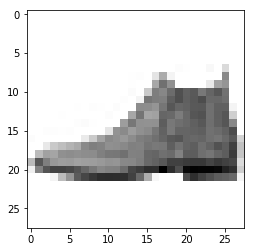

In [0]:

plt.imshow(test_images[0],cmap=plt.cm.binary)
plt.show()

Sweet !

## Convolutional Neural Networks

Now we know how to build a regular fully connected neural networks (MLP). But we are dealing with images, so this would make more sense to use 2D Convolution. 

To do so, we will rely on the same principles: build a sequential keras model, but now using Conv2D layers, Pooling and Dense.

But first, we need to reshape our inputs: right now, each example is a 2D matric of size 28x28, but Conv2D actually needs 3D inputs, with shape (height_of_image, width_of_image, number_of_channels). In our case, the number of channels is 1 (but e.g. RGB images will have 3 channels).


In [0]:

train_images = train_images.reshape((60000, 28, 28, 1))
test_images = test_images.reshape((10000, 28, 28, 1))


Let's build a sequential model with 3 Conv2D layers with kernel size of 3x3 and ReLU activation function, alternating with MaxPooling2D of size 2x2. The number of channels for each Conv2D layer will be resp. 16, 32, and 64.
You can also use BatchNormalization after each Convolution. 

After the Convolution + Pooling layer, you will need fully connected layers to go to your desired 10-size outputs. So you'll need to flatten the output of the last pooling layer, and stack some Dense layers as in the previous model.

 https://www.tensorflow.org/api_docs/python/tf/layers/conv2d
 
 https://www.tensorflow.org/api_docs/python/tf/layers/MaxPooling2D
 
 https://www.tensorflow.org/api_docs/python/tf/layers/BatchNormalization

In [0]:

model = tf.keras.models.Sequential()


model.add(tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(10, activation='softmax'))


W0827 09:20:56.285224 140552925038464 deprecation.py:506] From /usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling __init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [0]:
# Let's look at our model architecture:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 16)        160       
_________________________________________________________________
batch_normalization (BatchNo (None, 26, 26, 16)        64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 32)        4640      
_________________________________________________________________
batch_normalization_1 (Batch (None, 11, 11, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)         

You can compare the number of trainable parameters compared to the previous fully connected model. We have much less weights with this model...Will it still be able to predict correctly ?

Configure the training process with the _compile_ function as before:

In [0]:


model.compile(optimizer='adam',
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])


And now let's train

In [0]:

hist=model.fit(train_images, train_labels, epochs=3, batch_size=20, validation_split=20)


Epoch 1/3
60000/60000 [==============================] - 23s 378us/sample - loss: 0.4716 - acc: 0.8286
Epoch 2/3
60000/60000 [==============================] - 20s 330us/sample - loss: 0.3459 - acc: 0.8724
Epoch 3/3
60000/60000 [==============================] - 20s 333us/sample - loss: 0.3097 - acc: 0.8837


And evaluate on the test set

In [0]:
test_loss, test_acc = model.evaluate(test_images, test_labels)


10000/10000 [==============================] - 1s 98us/sample - loss: 0.3514 - acc: 0.8698


Now you can play around, trying different architectures and hyper parameters !

In [0]:
for layer in model.layers:
  # check for convolutional layer
  if 'conv' not in layer.name:
    continue
  filters, biases = layer.get_weights()
  print(layer.name, filters.shape)



conv2d (3, 3, 1, 16)
conv2d_1 (3, 3, 16, 32)
conv2d_2 (3, 3, 32, 64)


Tensorflow provides a list of available datasets that are ready to use : https://www.tensorflow.org/datasets/catalog/overview

In [0]:
cifar = keras.datasets.cifar10
(train_images, train_labels), (test_images, test_labels) = cifar.load_data()

class_names= ['airplane','car','bird','cat','deer','dog','frog','horse','ship','truck']
train_labels = train_labels.reshape(train_labels.shape[0])
print(train_images.shape)
train_images = train_images / 255.
test_images = test_images / 255.

170508288/170498071 [==============================] - 6s 0us/step
